# LSTM Model for PM2.5 Prediction

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
%load_ext tensorboard
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
dataset_path = 'dataset_after_feature_engineering.csv'
y_column = 'PM25'
X_columns = ['temperature', 'precipitation',
       'humidity', 'cloudiness', 'pressure', 'temperature1', 'humidity1',
       'lcz', '1', '2', '3', '4', '5', '6', '8', '9', '10', 'A', 'B', 'D', 'E','traffic', 'Wx', 'Wy', 'max Wx', 'max Wy',
       'timestamp_s', 'Day sin', 'Day cos', 'Year sin', 'Year cos'] 

stratification_column = 'sensor'

date = 'date'


In [3]:
len(X_columns)

31

## Loading the data

Loading

In [4]:
df = pd.read_csv(dataset_path)
df = df[df.notna()]
print(F"Number of records: {df.shape[0]}")
df.columns


Number of records: 374159


Index(['sensor', 'DateTime', 'PM25', 'temperature', 'precipitation',
       'humidity', 'cloudiness', 'pressure', 'temperature1', 'humidity1',
       'lcz', '1', '2', '3', '4', '5', '6', '8', '9', '10', 'A', 'B', 'D', 'E',
       'F', 'G', 'traffic', 'date', 'Wx', 'Wy', 'max Wx', 'max Wy',
       'timestamp_s', 'Day sin', 'Day cos', 'Year sin', 'Year cos'],
      dtype='object')

Reorder columns

In [5]:
df.insert(0, stratification_column,
          df.pop(stratification_column))

df = pd.concat([df.pop(x)
               for x in X_columns+[y_column, date, stratification_column]], axis=1)
df.head()


,temperature,precipitation,humidity,cloudiness,pressure,temperature1,humidity1,lcz,1,2,...,max Wx,max Wy,timestamp_s,Day sin,Day cos,Year sin,Year cos,PM25,date,sensor
0,-13,0,98,3,10057,10,91,5,0.0,0.23,...,-22.981333,-19.283628,1.609459e+09,-6.012051e-12,1.000000,0.010881,0.999941,61.3,2021-01-01,5
1,-18,0,98,5,10060,10,91,5,0.0,0.23,...,-28.190779,-10.260604,1.609463e+09,2.588190e-01,0.965926,0.011597,0.999933,319.9,2021-01-01,5
2,-12,0,98,2,10062,0,91,5,0.0,0.23,...,-25.980762,-15.000000,1.609466e+09,5.000000e-01,0.866025,0.012314,0.999924,121.3,2021-01-01,5
3,-6,0,98,8,10060,0,91,5,0.0,0.23,...,-22.981333,-19.283628,1.609470e+09,7.071068e-01,0.707107,0.013031,0.999915,119.0,2021-01-01,5
4,2,0,98,8,10061,0,91,5,0.0,0.23,...,-25.980762,-15.000000,1.609474e+09,8.660254e-01,0.500000,0.013747,0.999905,139.1,2021-01-01,5


Describe

In [6]:
column_list = list(df.columns)  # Convert the columns attribute to a list

print(column_list)  # Print the list of column names

['temperature', 'precipitation', 'humidity', 'cloudiness', 'pressure', 'temperature1', 'humidity1', 'lcz', '1', '2', '3', '4', '5', '6', '8', '9', '10', 'A', 'B', 'D', 'E', 'traffic', 'Wx', 'Wy', 'max Wx', 'max Wy', 'timestamp_s', 'Day sin', 'Day cos', 'Year sin', 'Year cos', 'PM25', 'date', 'sensor']


In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temperature,374159.0,1.131155e+02,6.452959e+01,-9.700000e+01,6.500000e+01,1.110000e+02,1.610000e+02,3.540000e+02
precipitation,374159.0,8.642155e-01,5.458657e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.650000e+02
humidity,374159.0,7.855885e+01,1.467414e+01,2.200000e+01,6.900000e+01,8.200000e+01,9.000000e+01,1.000000e+02
cloudiness,374159.0,6.020291e+00,3.102774e+00,0.000000e+00,4.000000e+00,8.000000e+00,8.000000e+00,9.000000e+00
pressure,374159.0,1.016439e+04,9.980498e+01,9.797000e+03,1.010300e+04,1.017200e+04,1.023300e+04,1.045500e+04
temperature1,374159.0,1.381655e+02,6.806819e+01,-9.700000e+01,9.000000e+01,1.400000e+02,1.900000e+02,4.200000e+02
humidity1,374159.0,8.253530e+01,1.597203e+01,2.200000e+01,7.200000e+01,8.600000e+01,9.600000e+01,1.000000e+02
lcz,374159.0,6.818120e+00,3.185753e+00,2.000000e+00,5.000000e+00,6.000000e+00,9.000000e+00,1.500000e+01
1,374159.0,1.925743e-02,4.871910e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.900000e-01
2,374159.0,6.009608e-02,1.364914e-01,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e-02,5.100000e-01


### Split train and test
#### separate two last months data for testing set

In [8]:
import pandas as pd

# Assuming your date column is already in datetime format
df['date'] = pd.to_datetime(df['date'])

cut_line = pd.to_datetime('2022-11-01')

training_mask = df['date'] < cut_line
test_mask = (df['date'] >= cut_line) & (df['date'] <= '2022-12-31')

train_df = df[training_mask]
print(f"Number of train records: {train_df.shape[0]}")

test_df = df[test_mask]
print(f"Number of test records: {test_df.shape[0]}")


Number of train records: 340473
Number of test records: 33686


## Normalization

In [14]:
t_mean = train_df[X_columns].mean()
t_std = train_df[X_columns].std()
train_df[X_columns] = (train_df[X_columns] - t_mean) / t_std
test_df[X_columns] = (test_df[X_columns] - t_mean) / t_std

/tmp/ipykernel_840/3923520792.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[X_columns] = (train_df[X_columns] - t_mean) / t_std
/tmp/ipykernel_840/3923520792.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[X_columns] = (test_df[X_columns] - t_mean) / t_std


In [15]:
#remove the date column

train_df = train_df.drop('date', axis=1)
test_df = test_df.drop('date', axis=1)

In [11]:
# Check for NaN values
nan_values = train_df.isna().sum()
print(nan_values)

temperature      0
precipitation    0
humidity         0
cloudiness       0
pressure         0
temperature1     0
humidity1        0
lcz              0
1                0
2                0
3                0
4                0
5                0
6                0
8                0
9                0
10               0
A                0
B                0
D                0
E                0
traffic          0
Wx               0
Wy               0
max Wx           0
max Wy           0
timestamp_s      0
Day sin          0
Day cos          0
Year sin         0
Year cos         0
PM25             0
sensor           0
dtype: int64


## Windowing

In [16]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, test_df=test_df,
                 label_columns=None, stratification_column=None):
        # Store the raw data.
        self.train_df = train_df
        self.test_df = test_df

        # Work out the label column indices.
        self. label_columns =  label_columns
        if  label_columns is not None:
            self. label_columns_indices = {name: i for i, name in
                                          enumerate (label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        # stratification_column
        self.stratification_column = stratification_column
        if not self.stratification_column is None:
            # ToDo: Check if the stratification_column is the last column or not. If not throw an exception
            pass

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[
            self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[
            self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self. label_columns}'])


def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self. label_columns is not None:
        labels = tf.stack([labels[:, :, self.column_indices[name]]
                           for name in self. label_columns], axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels


def make_dataset(self, data):

    def make_timeseries_dataset(data):
        data_np = None
        data_np = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data_np,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=False,
            batch_size=128,)

        return ds.map(self.split_window)

    if self.stratification_column is None:
        return make_timeseries_dataset(data)
    else:
        ds = None
        gb = data.groupby([self.stratification_column])
        for group_name, df_group in gb:
            if ds is None:
                ds = df_group.drop(columns=[self.stratification_column])
                ds = make_timeseries_dataset(ds)
            else:
                n_ds = df_group.drop(columns=[self.stratification_column])
                ds = ds.concatenate(make_timeseries_dataset(n_ds))

        return ds


@property
def train(self):
    return self.make_dataset(self.train_df)


@property
def test(self):
    return self.make_dataset(self.test_df)


@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result


WindowGenerator.split_window = split_window
WindowGenerator.make_dataset = make_dataset
WindowGenerator.train = train
WindowGenerator.test = test
WindowGenerator.example = example

In [17]:
wide_window = WindowGenerator(
    input_width=24, label_width=1, shift=1,
     label_columns=['PM25'], stratification_column=stratification_column)
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['PM25']

In [16]:
 #num_batches = 0
# for inputs, targets in wide_window.test:
 #    num_batches +=1
 #    print("---Batch---")
 #    print("Feature shape:", inputs.numpy().shape)
 #    print("Feature:", inputs.numpy())
 #    print("Label shape:", targets.numpy().shape)
  #   print("Label:", targets.numpy())
 #    print("")
 #    break
# print(num_batches)

## Model

In [86]:
wide_window.train

<ConcatenateDataset element_spec=(TensorSpec(shape=(None, 24, 32), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>

In [18]:
tr = wide_window.train
test_dataset = wide_window.test

num_samples = 0
for _ in tr:
    num_samples += 1
split_ratio = 0.8
num_train_samples = int(num_samples * split_ratio)
num_test_samples = num_samples - num_train_samples

tr = tr.shuffle(num_samples)

train_dataset = tr.take(num_train_samples)
val_dataset = tr.skip(num_train_samples)

2023-07-01 12:35:25.766161: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


## LSTM Model

In [17]:
lstm_model = tf.keras.Sequential([
    # LSTM layers
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),   
    # Dense layers for prediction
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)  # Output layer with 1 neuron for regression
])


In [18]:

# Define a callback to save the weights of the best epoch
checkpoint_filepath = 'lstm_best_weights5.h5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, save_best_only=True, save_weights_only=True, verbose=1, monitor='val_loss')

# Compile the model
lstm_model.compile(#loss=tf.keras.losses.Huber(),
                   loss = tf.keras.losses.MeanSquaredError(),
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   metrics=['mae'])

# Fit the model
history = lstm_model.fit(train_dataset, epochs=200, validation_data=val_dataset, callbacks=[checkpoint_callback])

# Save the trained model
lstm_model.save('lstm_model_best_weights5')



Epoch 1/200
2127/2128 [============================>.] - ETA: 0s - loss: 30.6535 - mae: 3.2376
Epoch 1: val_loss improved from inf to 20.94699, saving model to lstm_best_weights5.h5
2128/2128 [==============================] - 75s 27ms/step - loss: 30.6609 - mae: 3.2378 - val_loss: 20.9470 - val_mae: 3.0115
Epoch 2/200
2127/2128 [============================>.] - ETA: 0s - loss: 21.4431 - mae: 2.6678
Epoch 2: val_loss improved from 20.94699 to 18.86751, saving model to lstm_best_weights5.h5
2128/2128 [==============================] - 64s 26ms/step - loss: 21.4363 - mae: 2.6675 - val_loss: 18.8675 - val_mae: 2.3816
Epoch 3/200
2126/2128 [============================>.] - ETA: 0s - loss: 20.7510 - mae: 2.6215
Epoch 3: val_loss improved from 18.86751 to 16.43016, saving model to lstm_best_weights5.h5
2128/2128 [==============================] - 65s 26ms/step - loss: 20.7459 - mae: 2.6218 - val_loss: 16.4302 - val_mae: 2.2161
Epoch 4/200
2127/2128 [============================>.] - ETA: 0

INFO:tensorflow:Assets written to: lstm_model_best_weights5/assets


INFO:tensorflow:Assets written to: lstm_model_best_weights5/assets


In [19]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 256)           295936    
                                                                 
 lstm_1 (LSTM)               (None, 24, 128)           197120    
                                                                 
 lstm_2 (LSTM)               (None, 24, 64)            49408     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

## Evaluation

In [19]:
from tensorflow.keras.models import load_model

# Load the saved model
lstm_model = load_model('lstm_model_best_weights5')

# Load the best weights
lstm_model.load_weights('lstm_best_weights5.h5')

Best Epoch: 188


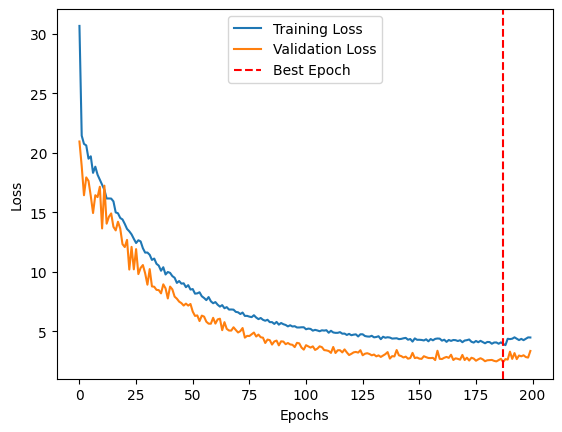

In [20]:

# Find the best epoch
best_epoch = np.argmin(history.history['val_loss']) + 1
print("Best Epoch:", best_epoch)

# Plot the training/validation loss with the best epoch indicated
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axvline(x=best_epoch-1, color='r', linestyle='--', label='Best Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
y_val_predicted = []
y_val = []

for inputs, targets in val_dataset:
    # Predict the outputs using the model
    predictions = lstm_model.predict(inputs)
    
    # Collect the predicted and true values
    y_val_predicted.extend(predictions)
    y_val.extend(targets.numpy().flatten())


4/4 [==============================] - 0s 14ms/step


In [21]:
test_results = lstm_model.evaluate(test_dataset, verbose=1)
print(
        f'Test measures (best epoch): {test_results}')
y_test_predicted = lstm_model.predict(test_dataset)

270/270 [==============================] - 7s 13ms/step - loss: 26.5852 - mae: 3.2009
Test measures (best epoch): [26.585186004638672, 3.2008864879608154]
270/270 [==============================] - 5s 12ms/step


In [22]:
y_test = []
for inputs, targets in test_dataset:
    [y_test.append(x) for x in targets.numpy().flatten()]

In [30]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Calculate RMSE for validation set
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_predicted))
print("Validation RMSE:", val_rmse)

# Calculate MAE for validation set
val_mae = mean_absolute_error(y_val, y_val_predicted)
print("Validation MAE:", val_mae)

# Calculate R-squared for validation set
val_r2 = r2_score(y_val, y_val_predicted)
print("Validation R-squared:", val_r2)

# Calculate RMSE for testing set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_predicted))
print("Testing RMSE:", test_rmse)

# Calculate MAE for testing set
test_mae = mean_absolute_error(y_test, y_test_predicted)
print("Testing MAE:", test_mae)

# Calculate R-squared for testing set
test_r2 = r2_score(y_test, y_test_predicted)
print("Testing R-squared:", test_r2)


Validation RMSE: 1.552993
Validation MAE: 1.1383028
Validation R-squared: 0.9688073864095486
Testing RMSE: 5.1560836
Testing MAE: 3.200885
Testing R-squared: 0.7493122266522099


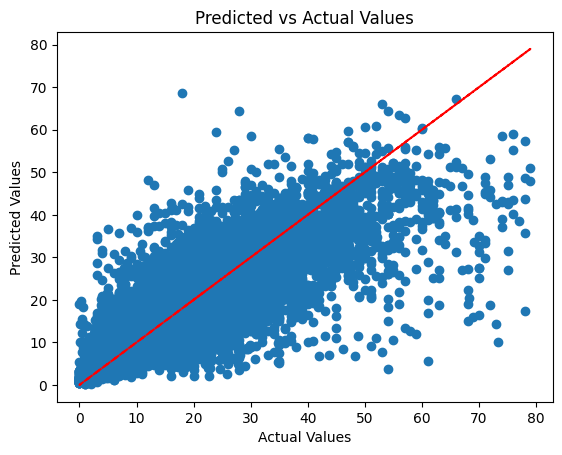

In [24]:
#Visualize predicted values agains the actual values
import matplotlib.pyplot as plt

plt.scatter(y_test, y_test_predicted)
plt.plot(y_test, y_test, 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()